# TamilHR-Net
****
- ### Joshua S Raju (22BAI1213)
- ### K V Hitesh Krishna (22BAI1036)
- ### Shantanu Wani (22BAI1403)

## Importing Dependencies

In [1]:
import cv2 
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from skimage.filters import sobel
from skimage.segmentation import watershed

## Functions

### Preprocessing Functions

In [2]:
def preprocessing(img, kernel=5, plot=0, plot_segmentation=0, plot_blur=0, otsu=0):
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1, 10, -1],
                               [-1, -1, -1]])
    sharpen = cv2.filter2D(img, -1, sharpen_kernel)
    gray = cv2.cvtColor(sharpen, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (kernel, kernel), 100)
    
    if otsu:
        _, threshold = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        _, threshold = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY_INV)
    elevation_map = sobel(threshold)
    markers = np.zeros_like(threshold)
    markers[threshold < 30] = 1
    markers[threshold > 150] = 2
    segmentation_ = watershed(elevation_map, markers)
    segmentation_noramlized = cv2.normalize(src = segmentation_, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    titles = ['ORIGINAL', 'GRAY+SHARPEN', 'BLUR', 'THRESHOLD', 'ELEVATION MAP', 'SEGMENTATION']
    images = [img, gray, blur, threshold, elevation_map, segmentation_]
    if plot:
        plt.figure(figsize=(20,20))
        for i in np.arange(len(images)):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i], 'gray')
            plt.title(titles[i])
            plt.axis('off')
        plt.show()
        
    if plot_blur:
        plt.imshow(blur, cmap='gray')
        plt.show()

    if plot_segmentation:
        plt.imshow(segmentation_noramlized, cmap='gray')
        plt.show()
        
    print('Returned segmented image.')
    return segmentation_noramlized

In [3]:
def detect(img, height=3, width=85, plot=0):
    kernel=np.ones((height, width),np.uint8)
    dilated=cv2.dilate(img, kernel, iterations=1)
    if plot:
        plt.imshow(dilated,'gray')
        plt.axis('off')
        plt.title('DETECTION')
        plt.show()
    print('Returned sentence_segmented imgage.')
    return dilated

In [4]:
def bounds(img, epsilon=5, x=0, y=0, plot=0):
    contours, hierarchy  = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_poly = [None] * len(contours)
    
    boundRect = []
    for i, c in enumerate(contours):
        if hierarchy [0][i][3] == -1:
            contours_poly[i] = cv2.approxPolyDP(c, epsilon, True)
            boundRect.append(cv2.boundingRect(contours_poly[i]))
    if x:
            boundRect = sorted(boundRect, key=lambda a: a[0], reverse=False)
    if y:
        boundRect = sorted(boundRect, key=lambda a: a[1], reverse=False)
    if plot:
        plot_bounds(img, boundRect)
    print('Returned list of bounding rectangles.')
    return boundRect

In [5]:
def segmented_list(img, boundRect, const_ht=0):
    segmented_list = []
    for i in range(len(boundRect)):
        x, y, w, h = boundRect[i]
        
        if w > 0 and h > 0:
            dimension_offset = 5
            position_offset = 2

            h = h + dimension_offset
            w = w + dimension_offset
            x = x - position_offset
            y = y - position_offset
            
            if const_ht:
                y=boundRect[i][1]
                h=boundRect[i][-1]
                
            croppedImg = img[y:y+h, x:x+w]
            segmented_list.append(croppedImg)
        
    print('Returned list of segmented images.')
    return segmented_list

### General Functions

In [6]:
def plot_bounds(img, bound_list):
    img_copy = img.copy()
    for i in range(len(bound_list)):
        color = (255, 0, 0)
        cv2.rectangle(img_copy, 
                     (int(bound_list[i][0]), int(bound_list[i][1])),
                     (int(bound_list[i][0] + bound_list[i][2]), 
                      int(bound_list[i][1] +bound_list[i][3])),
                      color, 2)
    plt.imshow(img_copy, 'gray')
    plt.title('DETECTED BOUNDINGS')
    plt.axis('off')
    plt.show()

In [7]:
def plot_segments(segmented_list, x=20, y=10):
    num_images = len(segmented_list)
    num_rows = int(np.ceil(num_images / 3))

    
    plt.figure(figsize=(x, y))
    for i in range(num_images):
        plt.subplot(num_rows, 3, i+1)
        plt.imshow(segmented_list[i])
        plt.title(f'SEGMENT {i+1}')
        plt.axis('off')
    plt.show()

In [8]:
def drop_zero_size_images(image_list):
    filtered_images = []
    for img in image_list:
        if 0 not in img.shape:
            filtered_images.append(img)

    print(f'Dropped Images: {len(image_list) - len(filtered_images)}')
    return filtered_images

In [9]:
def merge_boxes(bounding_boxes, size_threshold=0.5):
    merged_boxes = []

    for box in bounding_boxes:
        x, y, w, h = box
        updated_box = (x, y, x + w, y + h)

        overlapping = False
        for i, merged_box in enumerate(merged_boxes):
            mx1, my1, mx2, my2 = merged_box
            if (x >= mx1 and x <= mx2) or (mx1 >= x and mx1 <= x + w):
                box_area = w * h
                merged_box_area = (mx2 - mx1) * (my2 - my1)
                if box_area / merged_box_area < size_threshold:
                    merged_boxes[i] = (min(x, mx1), min(y, my1), max(x + w, mx2), max(y + h, my2))
                    overlapping = True
                    break

        if not overlapping:
            merged_boxes.append(updated_box)

    merged_boxes = [(x1, y1, x2 - x1, y2 - y1) for (x1, y1, x2, y2) in merged_boxes]

    return merged_boxes

## Document --> Lines

(834, 602, 3) (1754, 1240, 3)


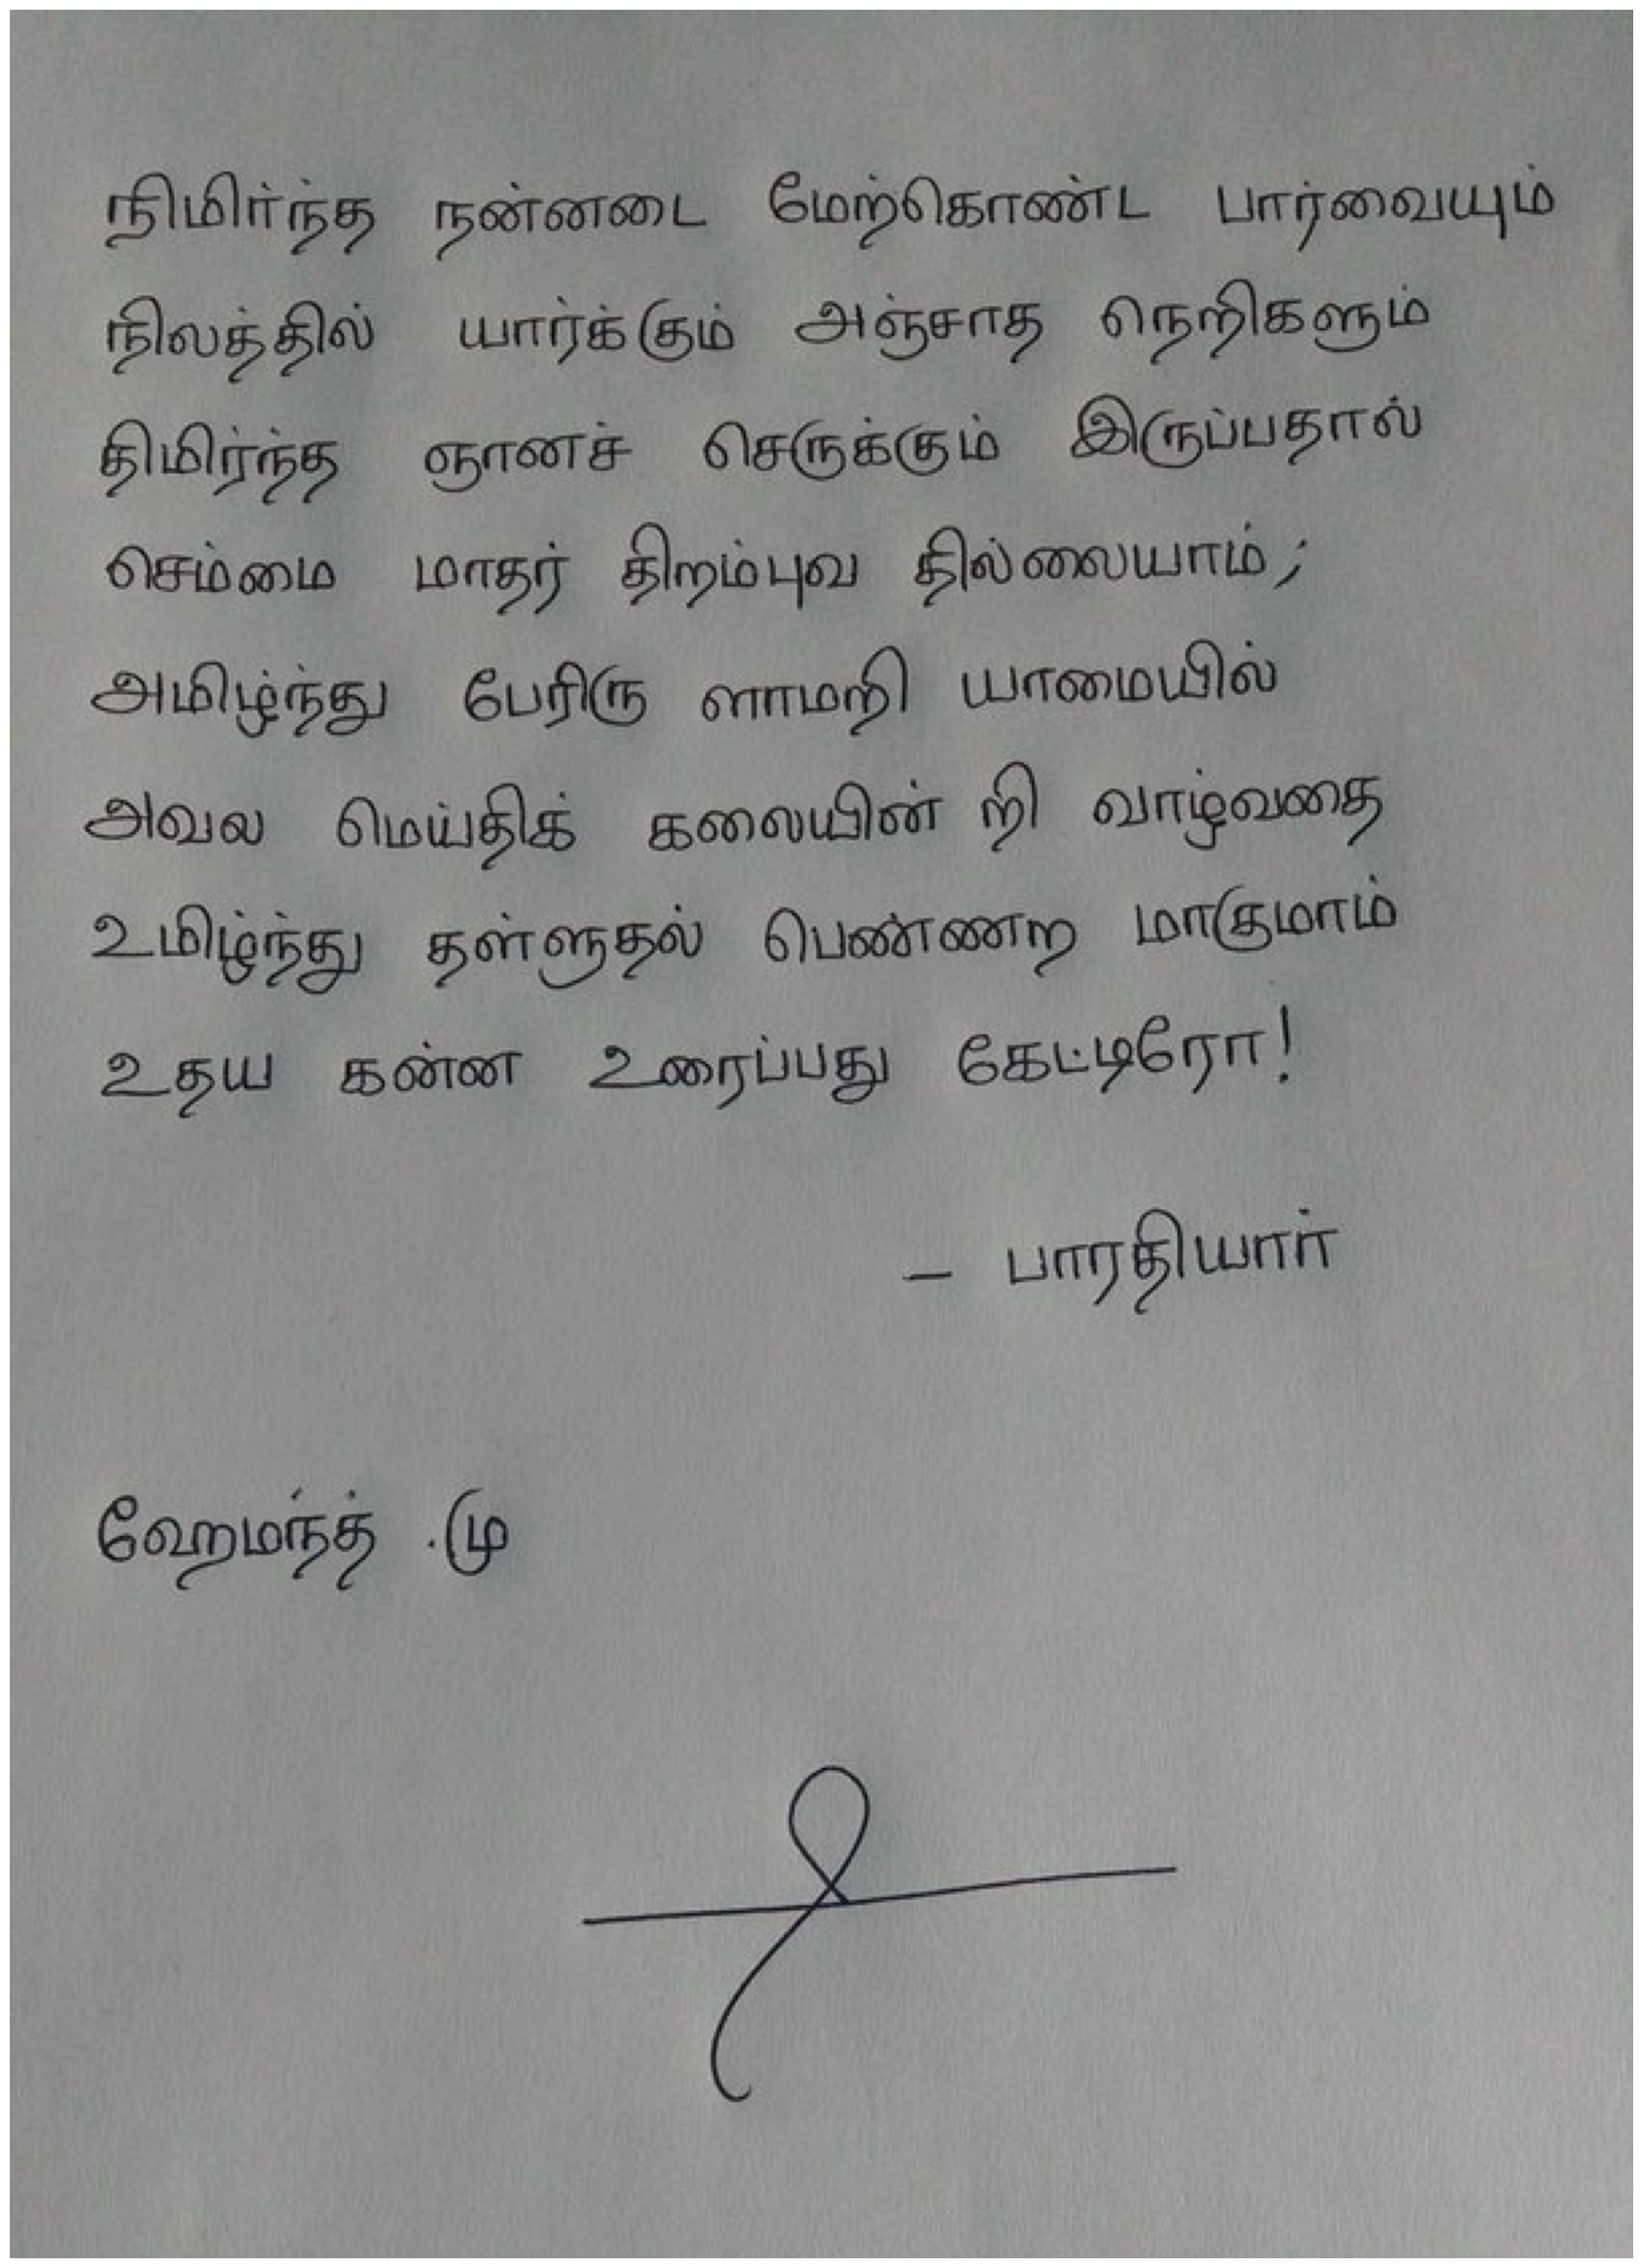

In [10]:
doc = cv2.imread('dataset/Handwrttingp2.jpg')
doc_resized = cv2.resize(doc, (1240, 1754))
print(doc.shape, doc_resized.shape)
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(doc)
plt.show()

In [11]:
preprocessed_doc = preprocessing(doc_resized, kernel=23, plot=0, otsu=1)
line_th = detect(preprocessed_doc, plot=0, height=5, width=85)
line_bounds= bounds(line_th, y=1, plot=0)
line_segmented_list = segmented_list(doc_resized, line_bounds)

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


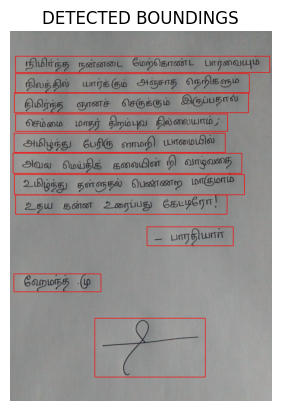

In [12]:
plot_bounds(doc_resized, line_bounds)

In [13]:
line_segmented_list = drop_zero_size_images(line_segmented_list)

Dropped Images: 0


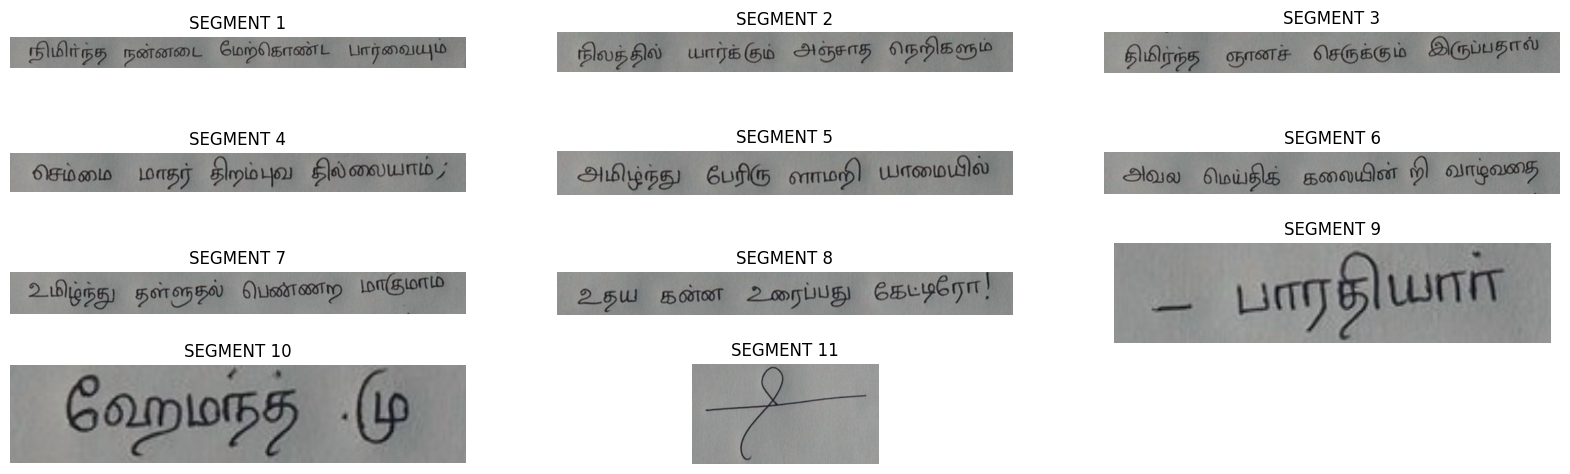

In [14]:
plot_segments(line_segmented_list, y=6)

In [15]:
len(line_segmented_list)

11

## Line --> Words

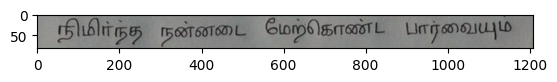

In [16]:
img = line_segmented_list[0]
plt.imshow(img)

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


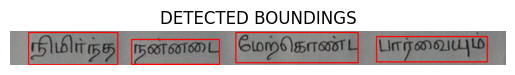

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


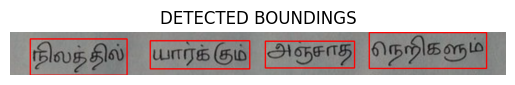

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


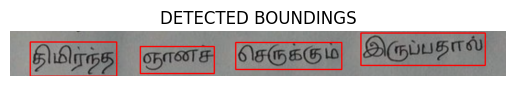

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


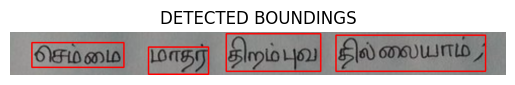

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


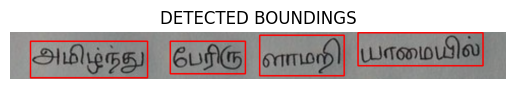

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


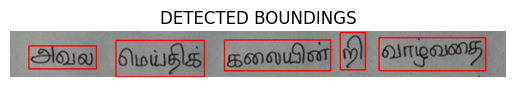

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


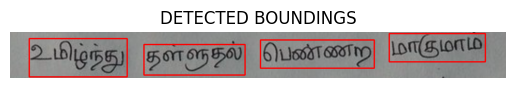

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


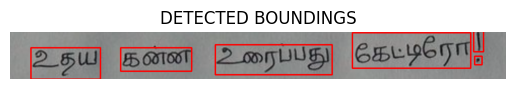

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


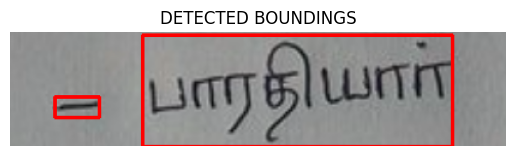

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


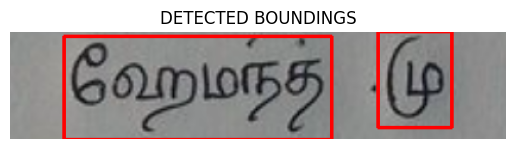

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


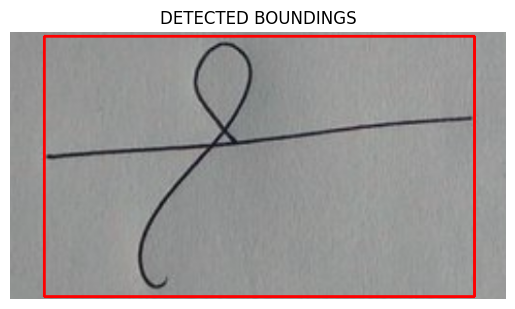

In [17]:
def word_segments(_list):
    word_segmented_list=[]
    j=0
    for i in _list:
        preprocessed = preprocessing(i, kernel=15, plot=0, otsu=1)
        th = detect(preprocessed, plot=0, height=6, width=5)
        word_bounds= bounds(th, x=1, plot=0)
        words = segmented_list(i, word_bounds)
        word_segmented_list.append(words)
        
        plot_bounds(line_segmented_list[j],word_bounds)
        j+=1
    return word_segmented_list
    
word_segmented_list = word_segments(line_segmented_list)

In [18]:
word_segmented_list[7][0].shape

(65, 146, 3)

In [19]:
drop_zero_size_images(word_segmented_list[7])

Dropped Images: 1


[array([[[144, 147, 145],
         [146, 148, 146],
         [149, 150, 148],
         ...,
         [125, 127, 127],
         [126, 128, 128],
         [128, 130, 130]],
 
        [[146, 148, 146],
         [146, 148, 146],
         [148, 149, 146],
         ...,
         [122, 125, 125],
         [124, 127, 127],
         [126, 129, 130]],
 
        [[147, 148, 146],
         [147, 148, 145],
         [149, 148, 144],
         ...,
         [119, 123, 124],
         [122, 126, 127],
         [124, 128, 129]],
 
        ...,
 
        [[143, 144, 142],
         [144, 144, 143],
         [146, 144, 144],
         ...,
         [132, 132, 132],
         [133, 133, 133],
         [134, 134, 134]],
 
        [[144, 145, 143],
         [145, 145, 143],
         [146, 145, 144],
         ...,
         [132, 132, 132],
         [133, 133, 133],
         [134, 134, 134]],
 
        [[144, 145, 143],
         [145, 145, 144],
         [146, 145, 144],
         ...,
         [133, 133, 133],
  

Dropped Images: 0


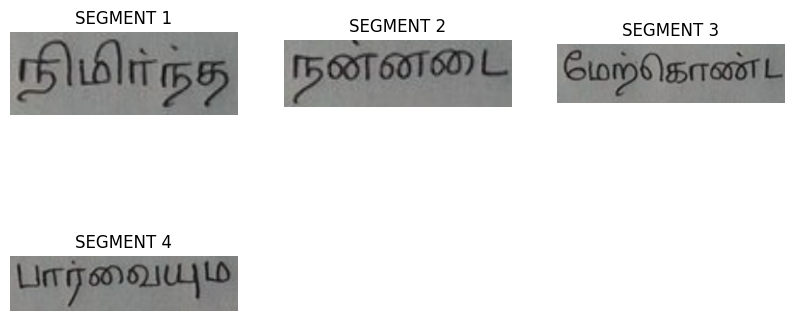

Dropped Images: 0


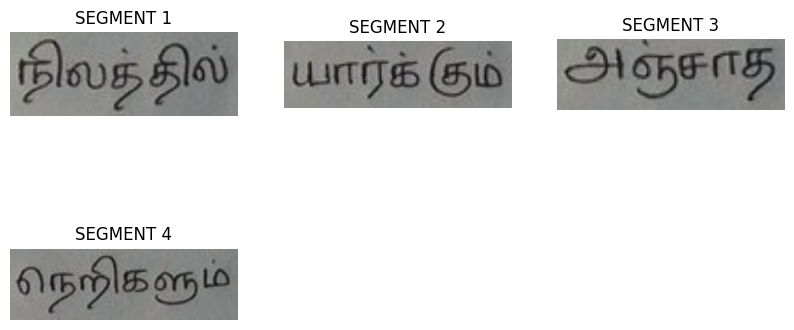

Dropped Images: 0


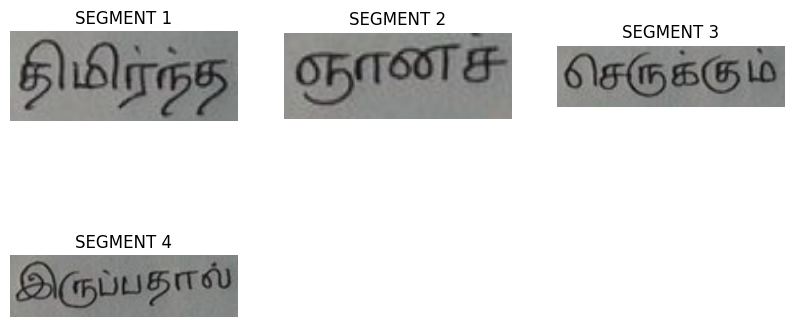

Dropped Images: 0


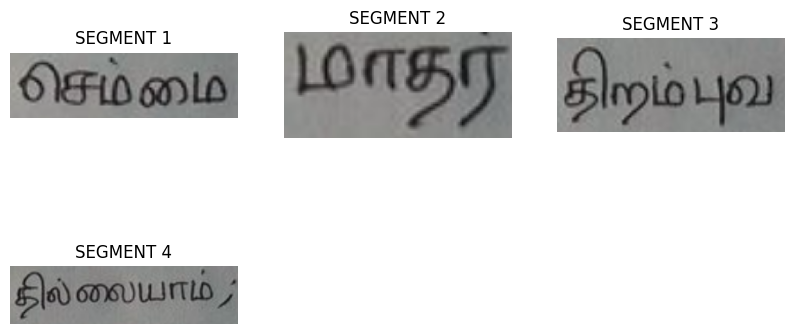

Dropped Images: 0


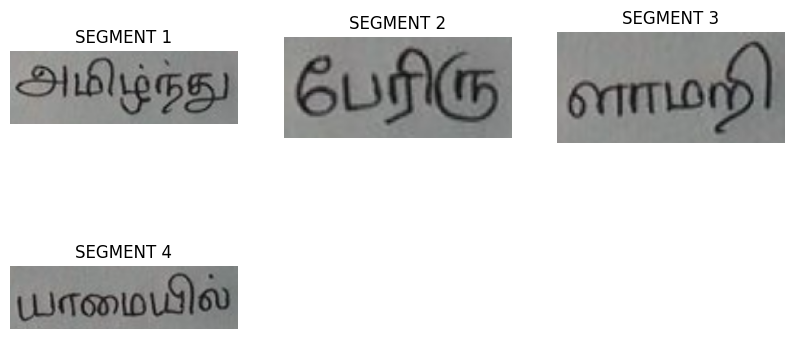

Dropped Images: 0


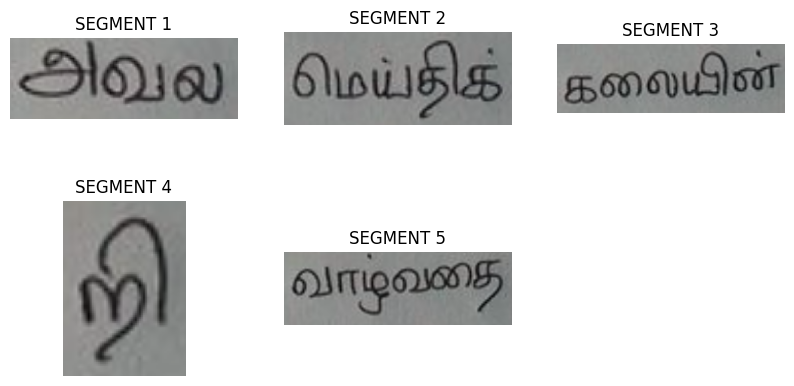

Dropped Images: 0


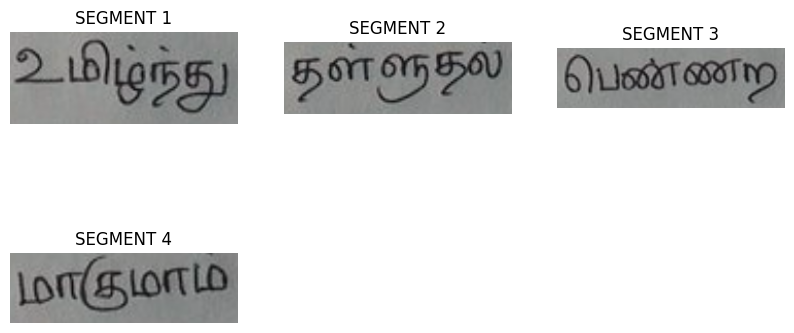

Dropped Images: 1
Dropped Images: 0


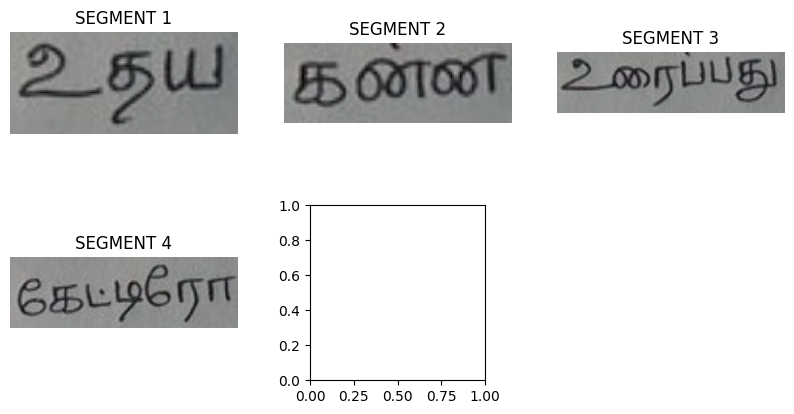

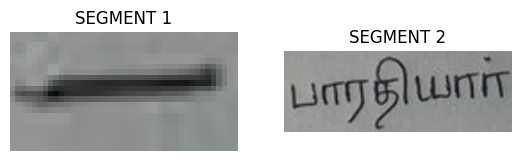

Dropped Images: 1
Dropped Images: 0


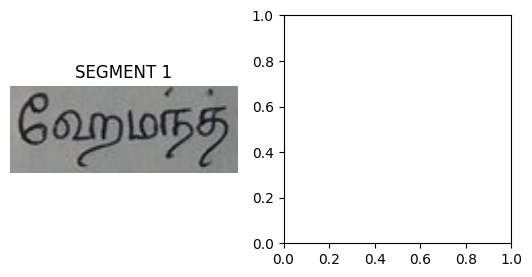

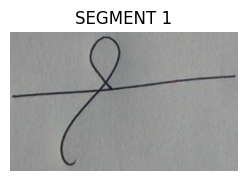

In [20]:
for i in word_segmented_list:
    drop_zero_size_images(i)
        
    try:
        plot_segments(i, x=10,y=5)
    except:
        pass

## Word --> Characters

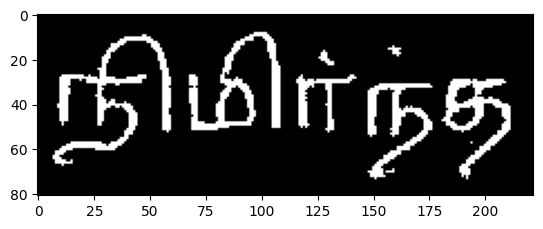

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


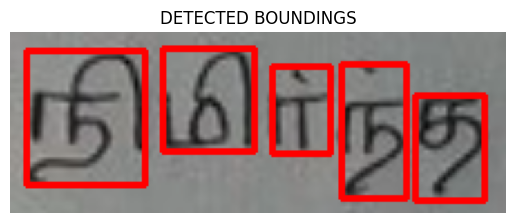

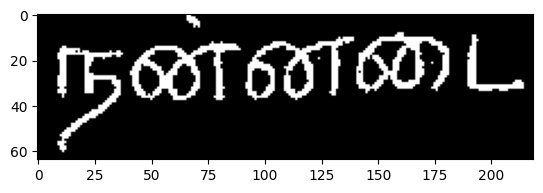

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


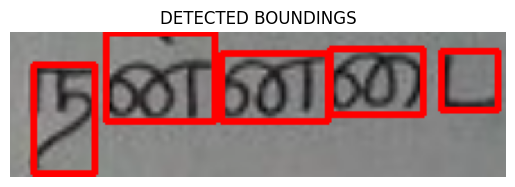

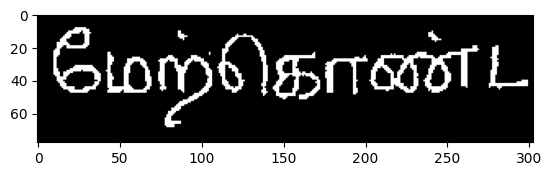

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


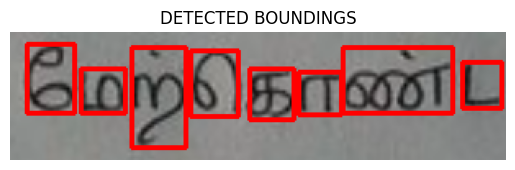

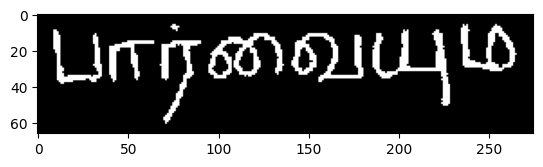

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


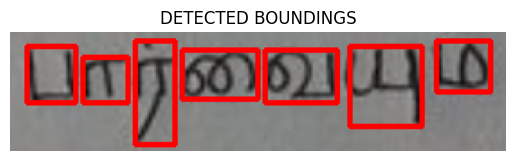

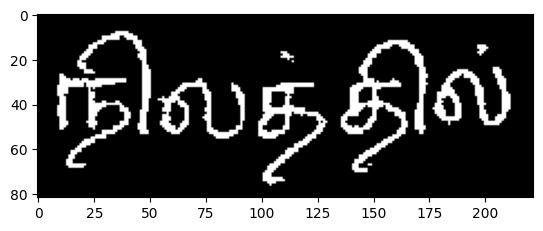

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


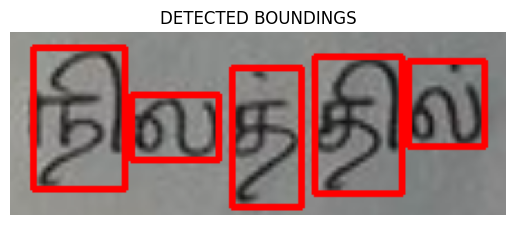

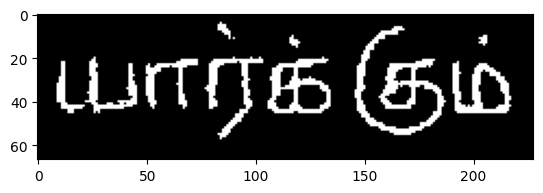

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


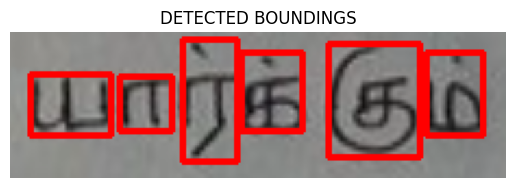

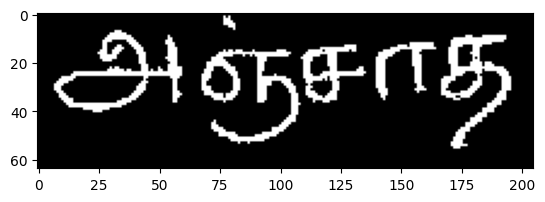

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


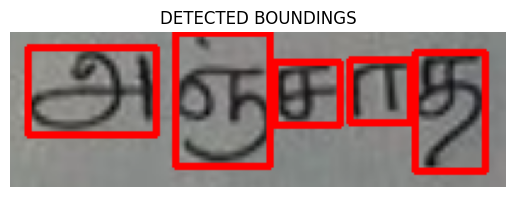

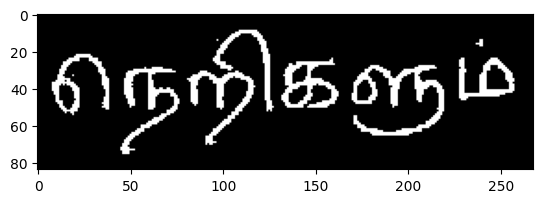

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


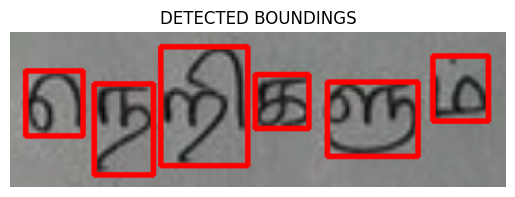

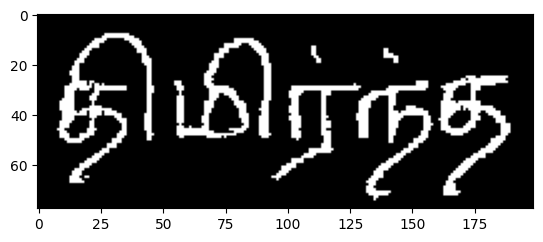

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


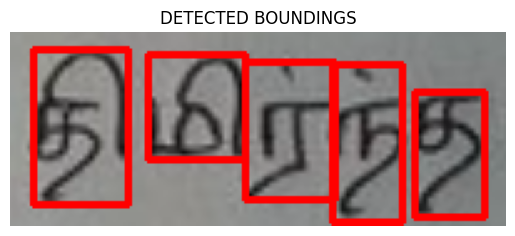

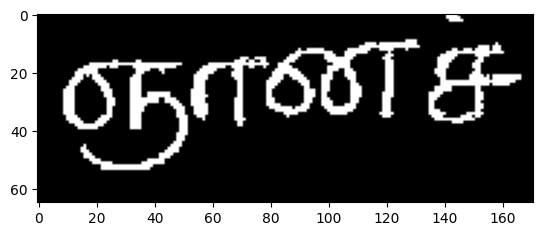

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


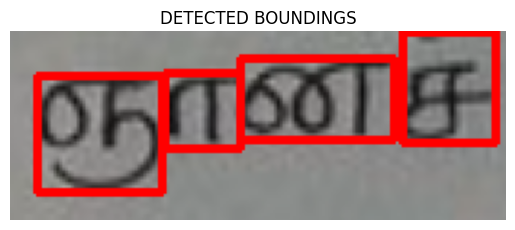

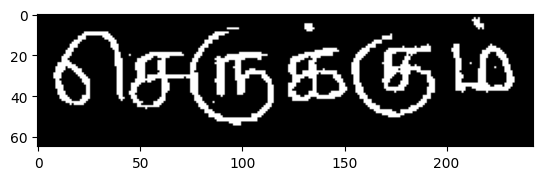

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


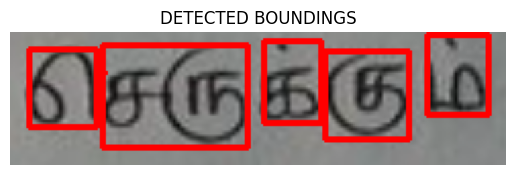

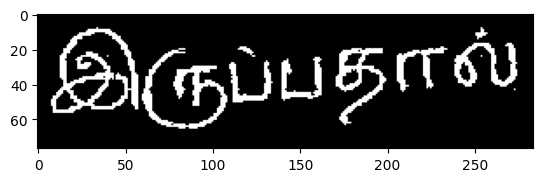

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


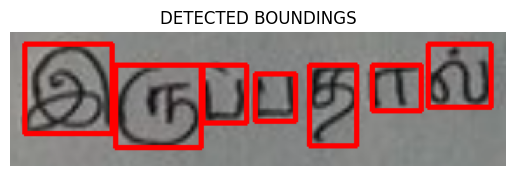

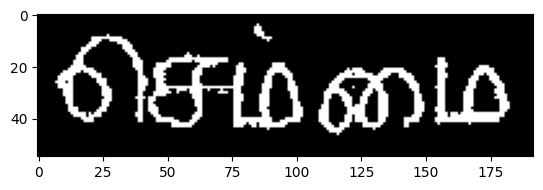

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


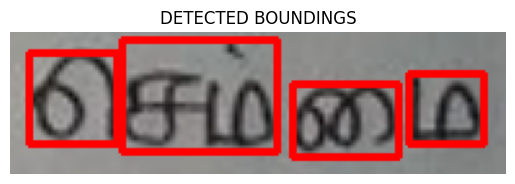

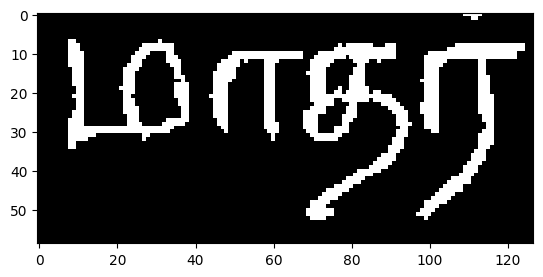

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


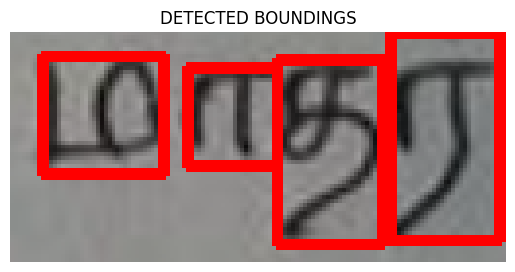

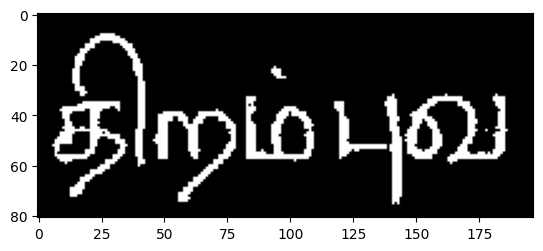

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


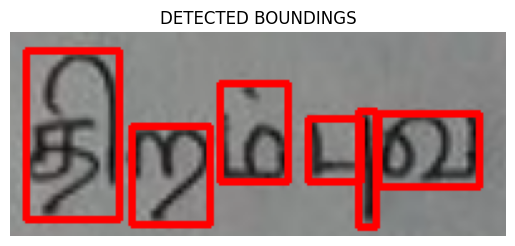

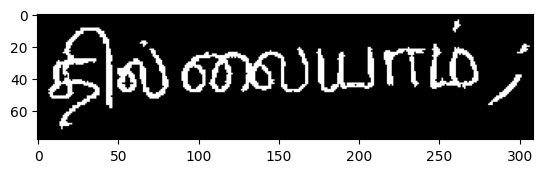

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


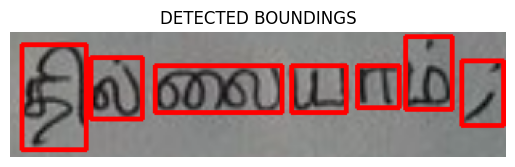

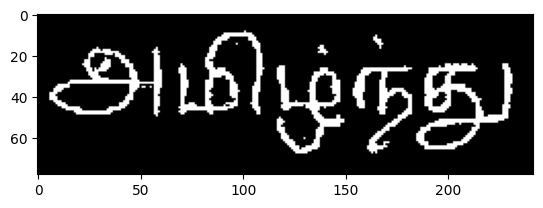

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


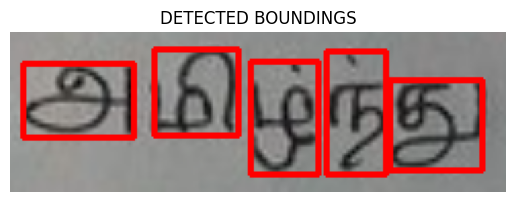

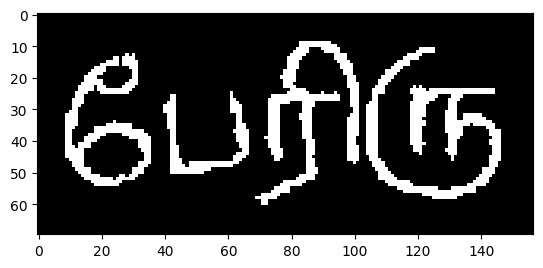

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


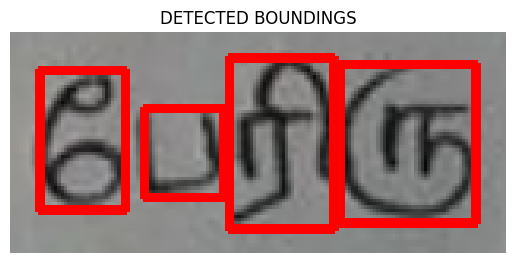

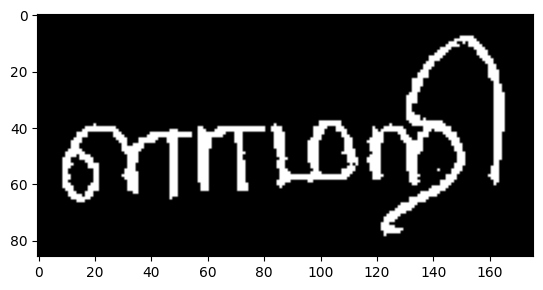

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


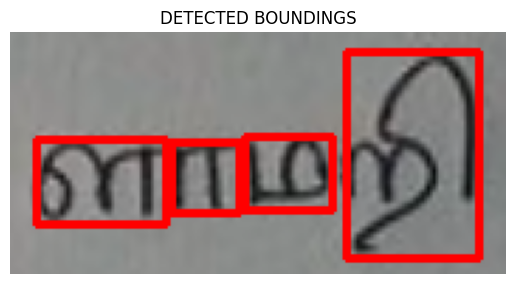

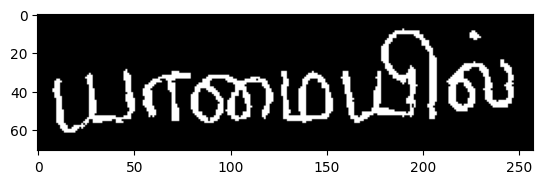

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


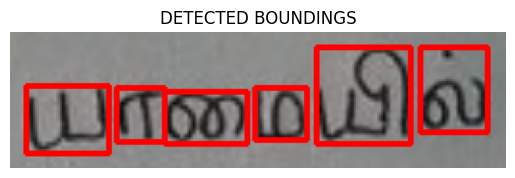

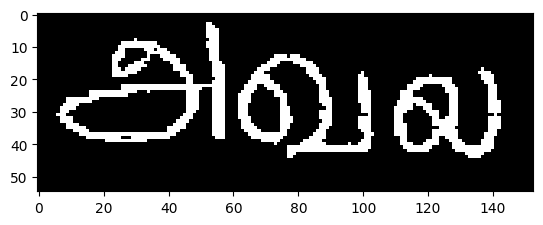

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


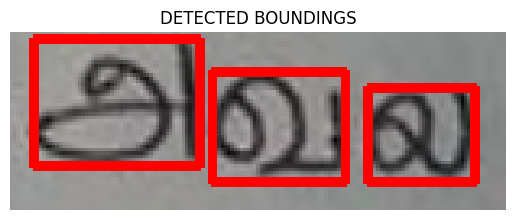

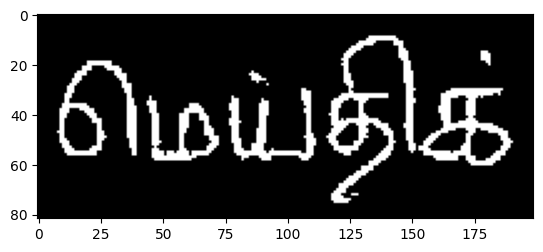

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


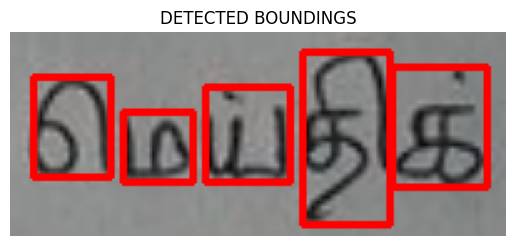

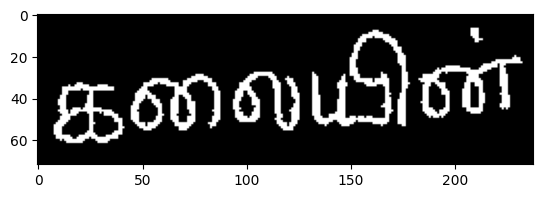

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


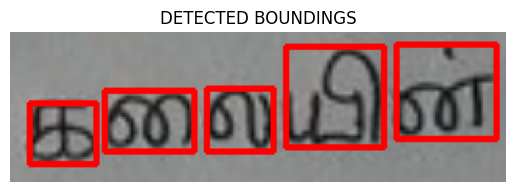

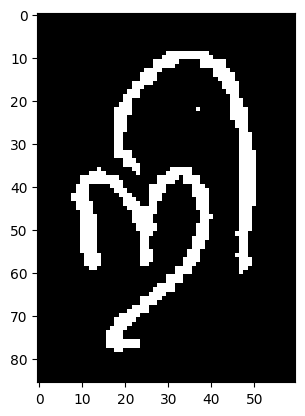

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


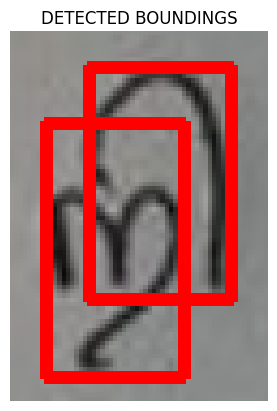

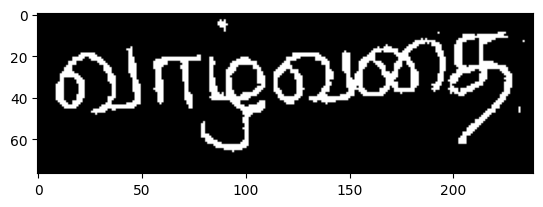

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


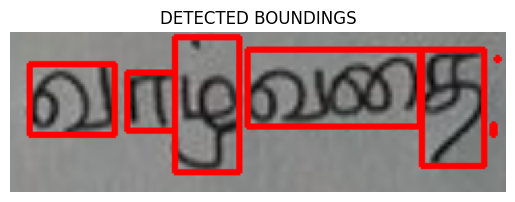

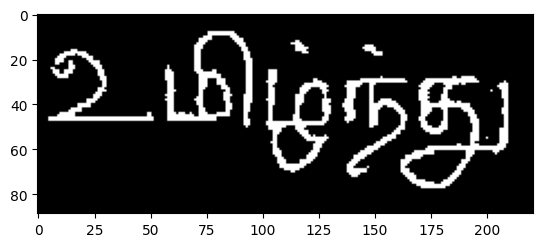

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


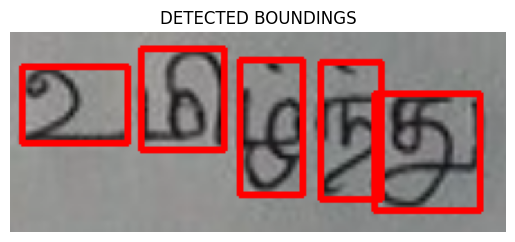

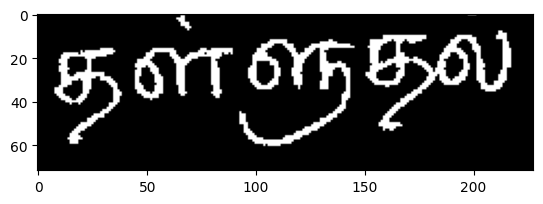

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


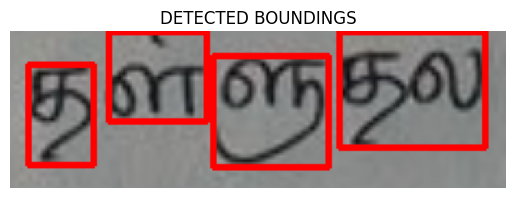

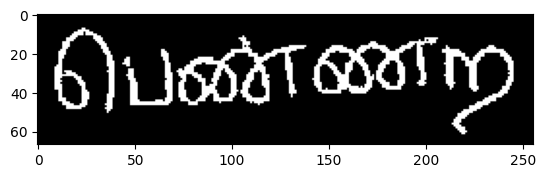

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


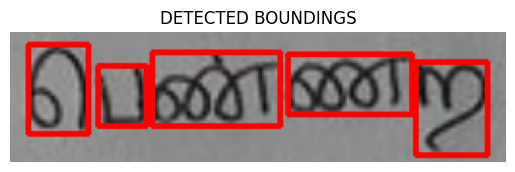

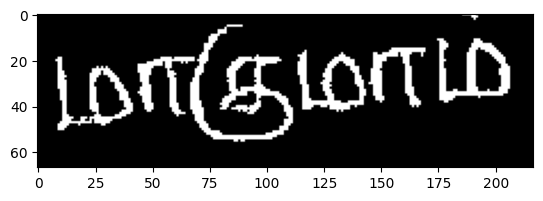

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


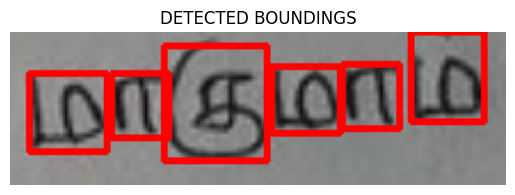

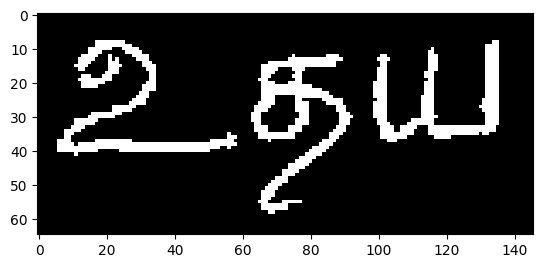

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


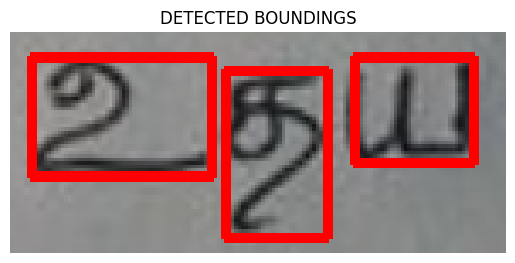

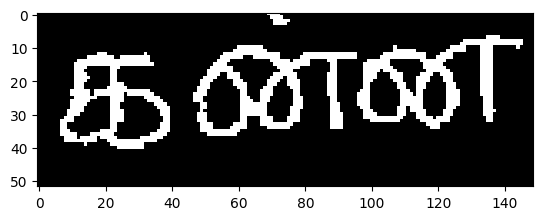

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


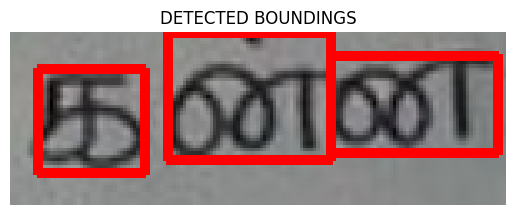

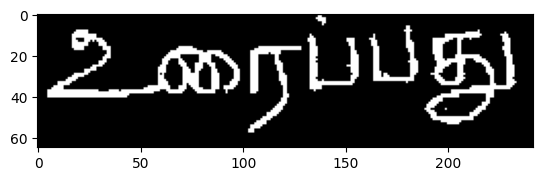

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


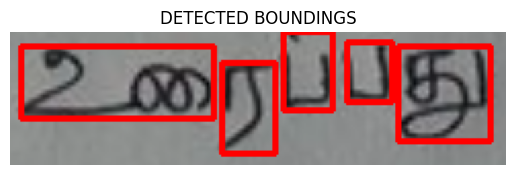

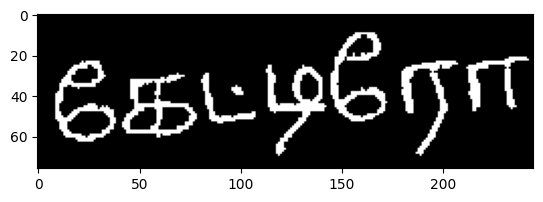

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


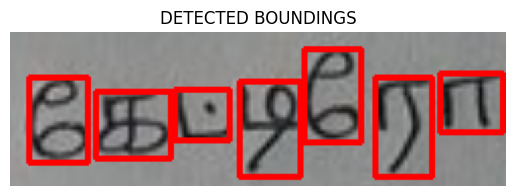

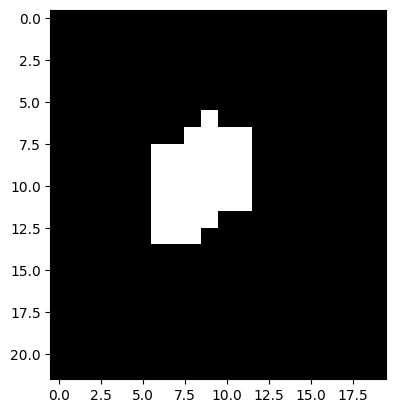

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


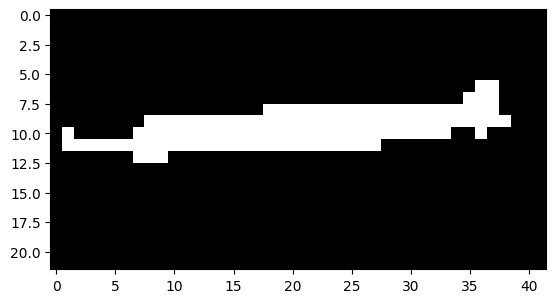

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


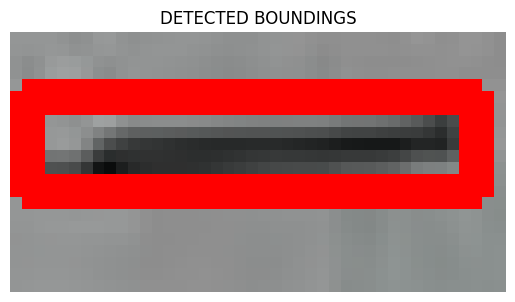

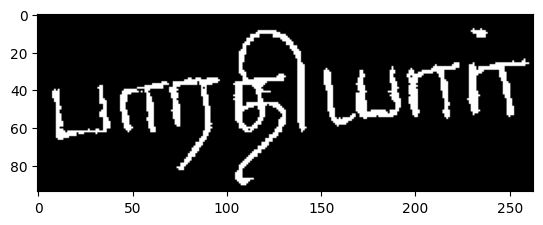

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


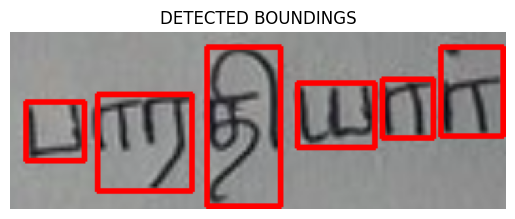

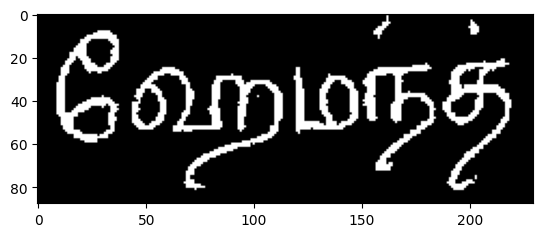

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


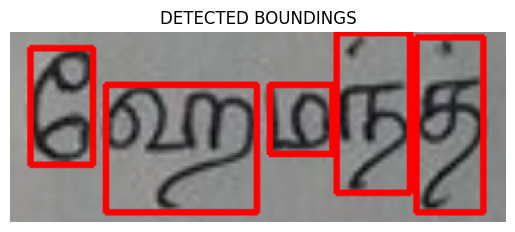

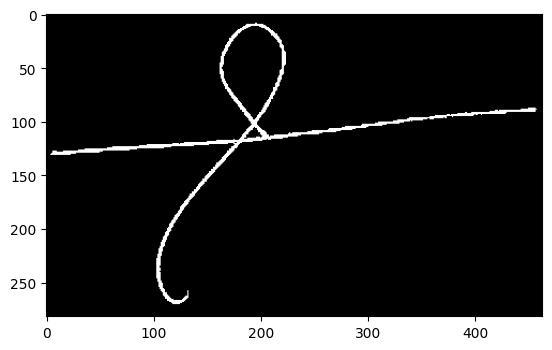

Returned segmented image.
Returned sentence_segmented imgage.
Returned list of bounding rectangles.
Returned list of segmented images.


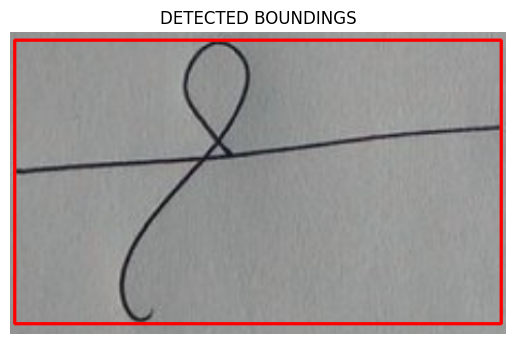

In [21]:
img = word_segmented_list[0][0]

def char_segments(_list):
    char_segmented_list=[]
    for j in range(len(_list)):
        k=0
        _word = []
        for i in _list[j]:
            try:
                preprocessed = preprocessing(i, kernel=1, plot_segmentation=1, otsu=1)
                th = detect(preprocessed, plot=0, height=3, width=1)
                char_bounds= bounds(th, epsilon=2, x=1, plot=0)
                updt_char_bounds = merge_boxes(char_bounds, 0.6)
                chars = segmented_list(i,updt_char_bounds)
                
                _word.append(chars)
                
                plot_bounds(word_segmented_list[j][k], updt_char_bounds)
                k+=1
            except:
                pass
        char_segmented_list.append(_word)
    return char_segmented_list
    
char_segmented_list = char_segments(word_segmented_list)

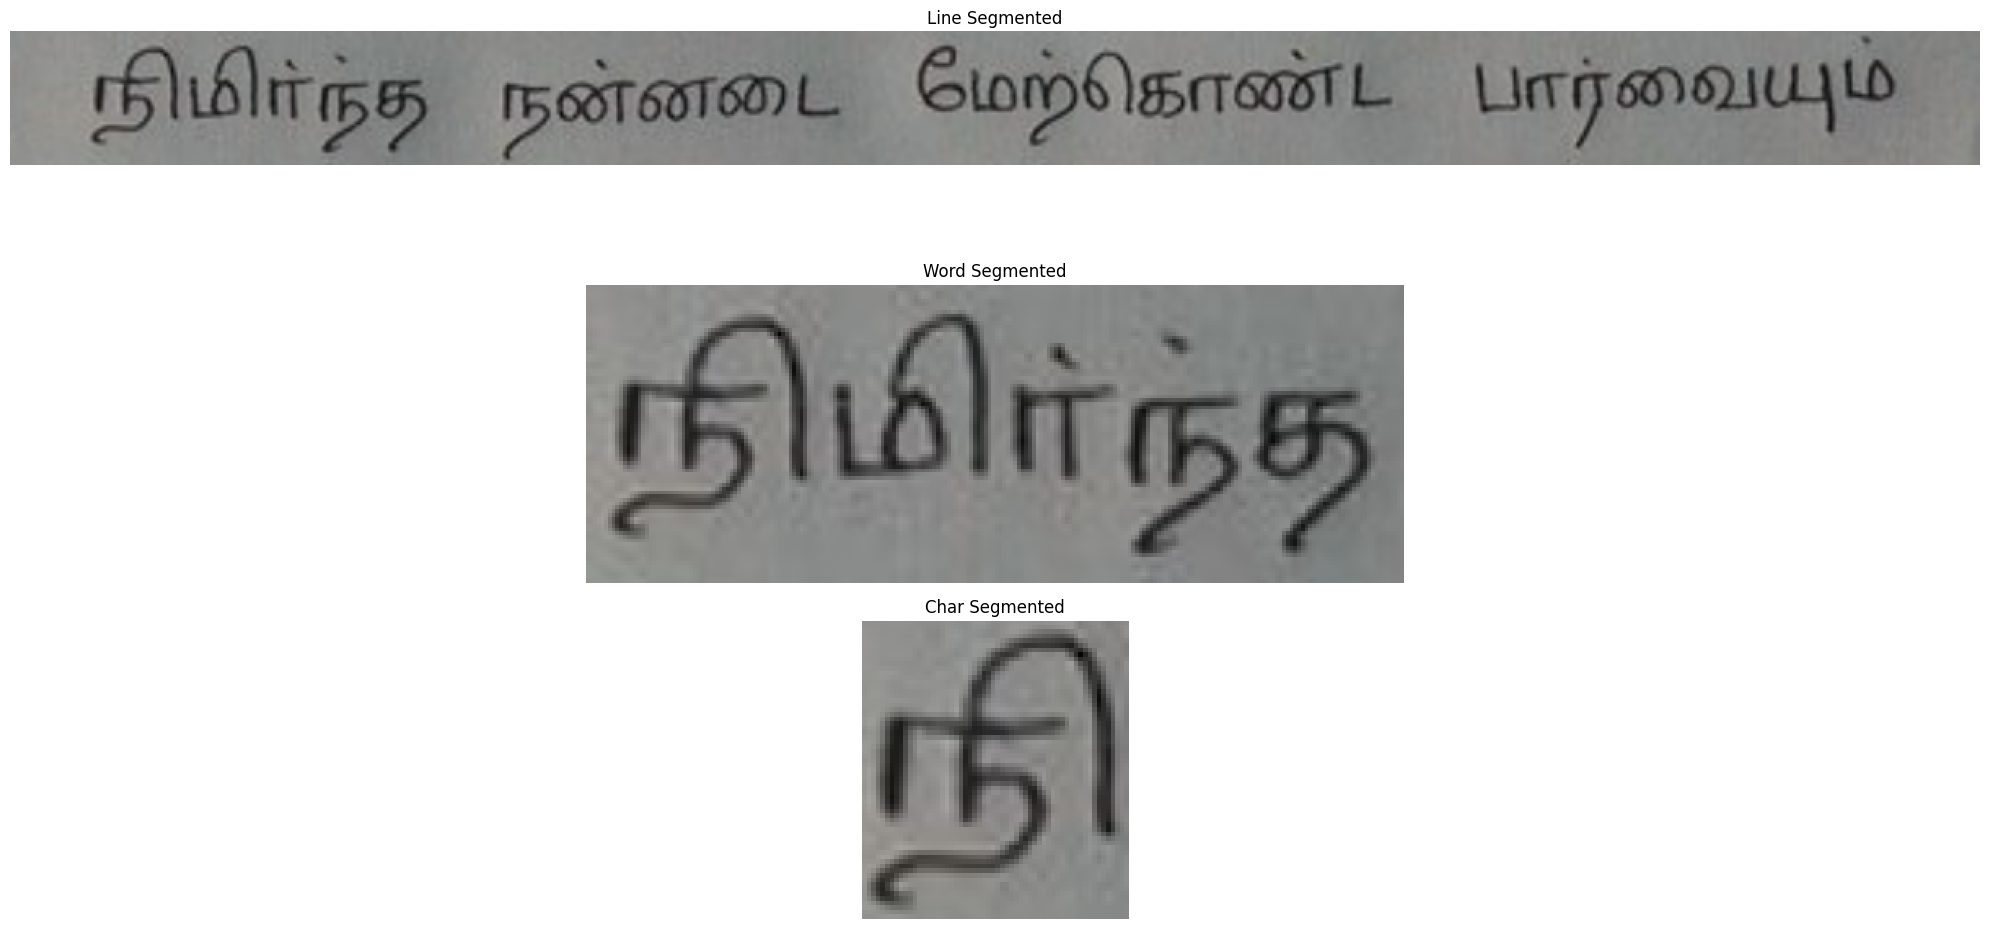

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.imshow(line_segmented_list[0])
plt.title('Line Segmented')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(word_segmented_list[0][0])
plt.title('Word Segmented')
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(char_segmented_list[0][0][0])
plt.title('Char Segmented')
plt.axis('off')

plt.tight_layout()
plt.show()

## Model 

In [23]:
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing import image

In [24]:
model = load_model('../Tamil-NN/modelfinalreduced.h5')
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 64, 64, 32)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 156)                 │          40,092 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,243,326 (16.19 MB)

 Trainable params: 4,243,324 (16.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [25]:
def predict_image(img, model):

    tamil_dict={0: 'ா', 1: 'அ', 2: 'ஆ', 3: 'இ', 4: 'ஈ', 5: 'உ', 6: 'ஊ', 7: 'எ', 8: 'ஏ', 9: 'ஐ', 10: 'ஒ', 11: 'ஓ', 12: 'ஔ', 13: 'ஃ', 14: 'க்', 
    15: 'க', 16: 'கி', 17: 'கீ', 18: 'கு', 19: 'கூ', 20: 'ச்', 21: 'ச', 22: 'சி', 23: 'சீ', 24: 'சு', 25: 'சூ', 26: 'ங்', 27: 'ங', 28: 'ஙி', 29: 'ஙீ', 30: 'ஙு', 
    31: 'ஙூ', 32: 'ஞ்', 33: 'ஞ', 34: 'ஞி', 35: 'ஞீ', 36: 'ஞு', 37: 'ஞூ', 38: 'ட்', 39: 'ட', 40: 'ழ',41: 'டீ', 42: 'டு', 43: 'டூ', 44: 'ண்', 45: 'ண', 
    46: 'ணி', 47: 'ணீ', 48: 'ணு', 49: 'ணூ', 50: 'த்', 51: 'த', 52: 'தி', 53: 'தீ', 54: 'து', 55: 'தூ', 56: 'ந்', 57: 'ந', 58: 'நி', 59: 'நீ', 60: 'நு',
    61: 'நூ', 62: 'ப்', 63: 'ப', 64: 'பி', 65: 'பீ', 66: 'பு', 67: 'பூ', 68: 'ம்', 69: 'ம', 70: 'மி', 71: 'மீ', 72: 'மு', 73: 'மூ', 74: 'ய்', 75: 'ய', 
    76: 'யி', 77: 'யீ',78: 'யு', 79: 'யூ', 80: 'ர்', 81: 'ர', 82: 'ரி', 83: 'ரீ', 84: 'ரு', 85: 'ரூ', 86: 'ல்', 87: 'ல', 88: 'லி', 89: 'லீ', 90: 'லு', 
    91: 'லூ', 92: 'ன்', 93: 'ன', 94: 'னி', 95: 'னீ', 96: 'ளு', 97: 'ளூ', 98: 'ற்', 99: 'ற', 100: 'றி', 101: 'றீ', 102: 'று', 103: 'றூ', 104: 'வ்', 
    105: 'வ', 106: 'வி', 107: 'வீ', 108: 'வு', 109: 'வூ', 110: 'ழ்', 111: 'ழ', 112: 'ழி', 113: 'ழீ', 114: 'ழு', 115: 'ழூ', 116: 'ன்', 117: 'ன', 118: 'னி',
    119: 'னீ', 120: 'னு',121: 'ஷி', 122: 'ஷீ', 123: 'ஷு', 124: 'ஷூ', 125: 'க்ஷ', 126: 'க்ஷ்', 127: ' க்ஷி', 128: ' க்ஷீ', 129: 'ஜு', 130: 'ஜூ', 
    131: 'ஹ', 132: 'ஹ்', 133: 'ஹி', 134: 'ஹீ', 135: 'ஹு', 136: 'ஹூ', 137: 'ஸ', 138: 'ஸ்', 139: 'ஸி', 140: 'ஸீ', 141: 'ஸு', 142: 'ஸூ', 
    143: 'ஷ', 144: 'ஷ்', 145: 'னூ', 146: 'ஶ்ரீ', 147: 'க்ஷூ', 148: 'ஜ', 149: 'ஜ்', 150: 'ஜி', 151: 'ஜீ', 152: 'க்ஷீ', 153: 'ெ', 154: 'ே', 155: 'ை'}
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    inv_thresh = cv2.bitwise_not(thresh)
    inverted=255-inv_thresh
    # plt.figure(figsize=(1,1))
    # plt.imshow(inverted, cmap='gray')
    # plt.show()
    
    masked_img_resized = cv2.resize(inverted, (64, 64))
    masked_img_resized = cv2.cvtColor(masked_img_resized, cv2.COLOR_GRAY2RGB)
    # plt.imshow(masked_img_resized)
    img_array = np.expand_dims(masked_img_resized, axis=0)
    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    # print("Predicted class:", tamil_dict[index])

    return tamil_dict[index]

In [26]:
print_line=[]
for line in range(len(line_segmented_list)):
    for word in range(len(word_segmented_list[line])):
        try:
            for char in char_segmented_list[line][word]:
                try:
                    pred_char = predict_image(char, model)
                    print_line.append(pred_char)
                except:
                    print_line.append('_')
        except:
            pass
        print_line.append('  ')
    print_line.append('\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

ரார்ர்த  ா_ஈஈட  ர்பற்ாரான்ட  ஃார்ஈாயுா  
ர்ாத்திா  பார்க்நட்  அ_ாஈத  ாநரிசரப  
ரிபிர்ந்த  ரஈஈ_  ாஃஞர்ர_  ர்நர்ாதாா  
ெர்ஈட  பரித_  திரட்பழா  திர்ஸபாம்ஃ  
யுாழந்து  ர்பரிரு  ரிாாரி  பரிஈாபிர்  
அர்பு  ாடப்திர்  ஈஈாபிர்  ற்ெ  ஙாழயிதரஃ  
உபிர்ர்ர  த_ர_  ாபஈனர  டெட்பா_  
டதப  ர_ஈ  பிர_பர்  ர்சடறர்ரா  சி    
ப்  ட்ரதபார்  
ாஹப_த்    
ர்  


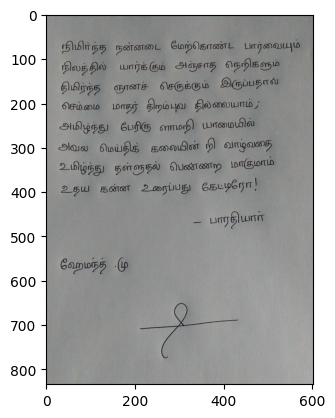

In [27]:
for i in print_line:
    print(i, end='')

plt.imshow(doc)